This notebook is the reproduction of [A Very Extensive Sberbank Exploratory Analysis](https://www.kaggle.com/captcalculator/a-very-extensive-sberbank-exploratory-analysis) notebook in python. Here i copied only titles, for more detailed description please refer to original notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

## Training Data

In [2]:
train_df = pd.read_csv("../input/train.csv", parse_dates=['timestamp'])
train_df['price_doc_log'] = np.log1p(train_df['price_doc'])

## Missing Data

In [3]:
train_na = (train_df.isnull().sum() / len(train_df)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)

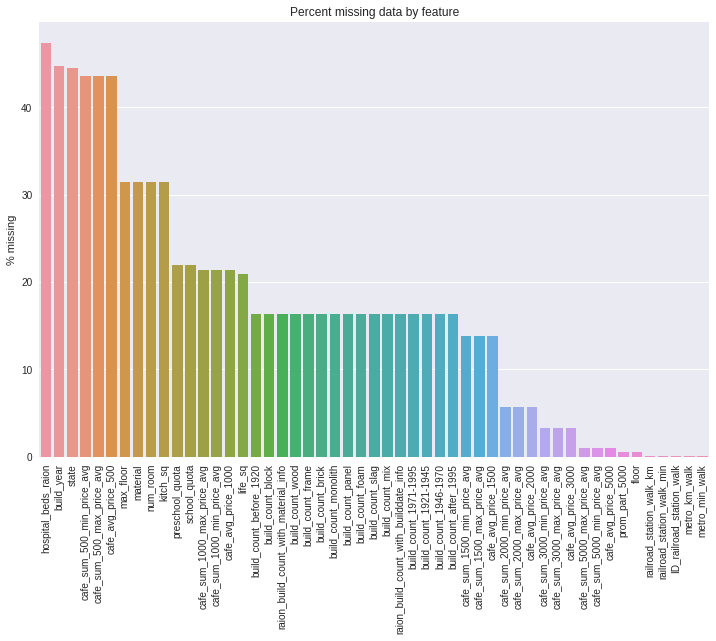

In [4]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
ax.set(title='Percent missing data by feature', ylabel='% missing')

## Data Quality Issues

In [5]:
# state should be discrete valued between 1 and 4. There is a 33 in it that is cleary a data entry error
# Lets just replace it with the mode.
train_df.loc[train_df['state'] == 33, 'state'] = train_df['state'].mode().iloc[0]

# build_year has an erronus value 20052009. Since its unclear which it should be, let's replace with 2007
train_df.loc[train_df['build_year'] == 20052009, 'build_year'] = 2007

## Housing Internal Characteristics

In [6]:
internal_chars = ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq', 'state', 'price_doc']
corrmat = train_df[internal_chars].corr()

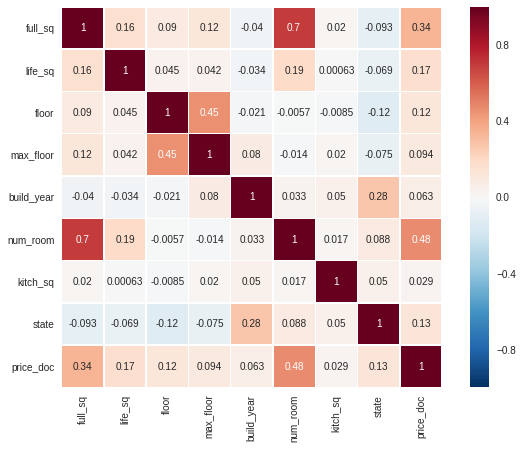

In [7]:
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

## Area of Home and Number of Rooms

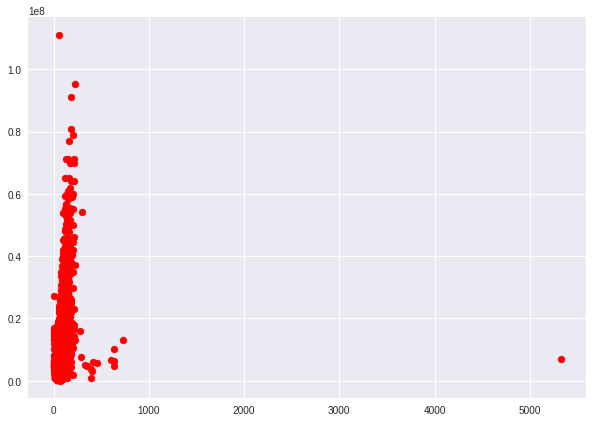

In [8]:
f, ax = plt.subplots(figsize=(10, 7))
plt.scatter(x=train_df['full_sq'], y=train_df['price_doc'], c='r')

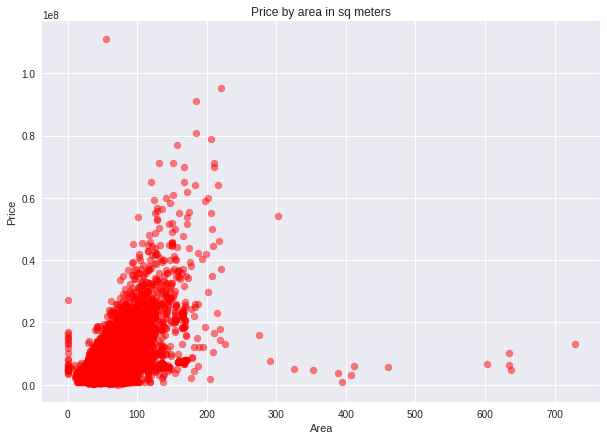

In [9]:
f, ax = plt.subplots(figsize=(10, 7))
ind = train_df[train_df['full_sq'] > 2000].index
plt.scatter(x=train_df.drop(ind)['full_sq'], y=train_df.drop(ind)['price_doc'], c='r', alpha=0.5)
ax.set(title='Price by area in sq meters', xlabel='Area', ylabel='Price')

In [10]:
(train_df['life_sq'] > train_df['full_sq']).sum()

37

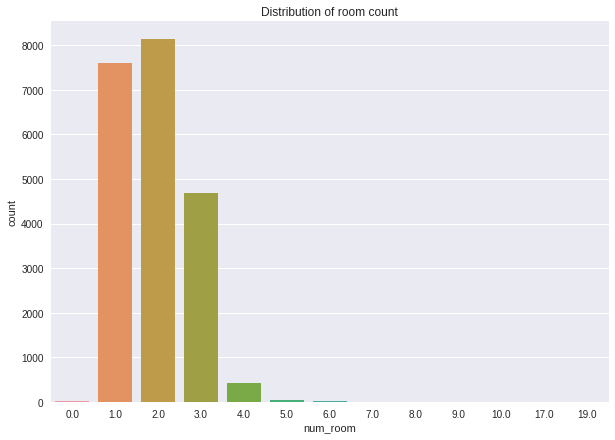

In [11]:
f, ax = plt.subplots(figsize=(10, 7))
sns.countplot(x=train_df['num_room'])
ax.set(title='Distribution of room count', xlabel='num_room')

## Sale Type

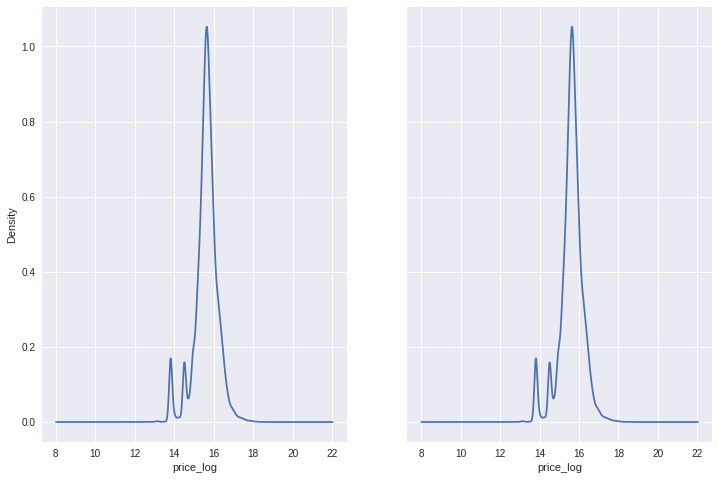

In [12]:
#can't plot density graph due to bug in kaggle kernels
#https://github.com/mwaskom/seaborn/issues/1103
#g = sns.FacetGrid(train_df, col="product_type", size=6)
#g.map(sns.kdeplot, "price_doc_log", color="r", shade=True)
#g.add_legend()
#ax.set(ylabel='density')

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
train_df.drop(train_df['product_type'] == 'Investment')["price_doc_log"].plot.kde(ax=ax[0])
train_df.drop(train_df['product_type'] == 'OwnerOccupier')["price_doc_log"].plot.kde(ax=ax[1])
ax[0].set(xlabel='price_log')
ax[1].set(xlabel='price_log')

In [13]:
train_df.groupby('product_type')['price_doc'].median()

product_type
Investment       6670000
OwnerOccupier    5564090
Name: price_doc, dtype: int64

## Build Year

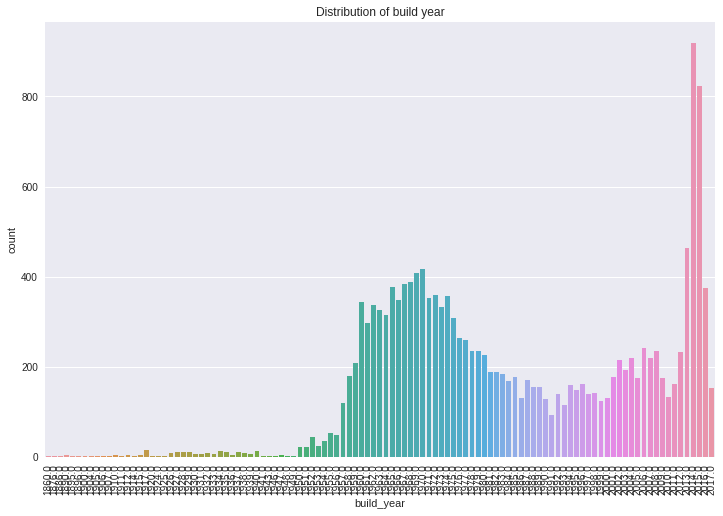

In [14]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90')
ind = train_df[(train_df['build_year'] <= 1691) | (train_df['build_year'] >= 2018)].index
by_df = train_df.drop(ind).sort_values(by=['build_year'])
sns.countplot(x=by_df['build_year'])
ax.set(title='Distribution of build year')

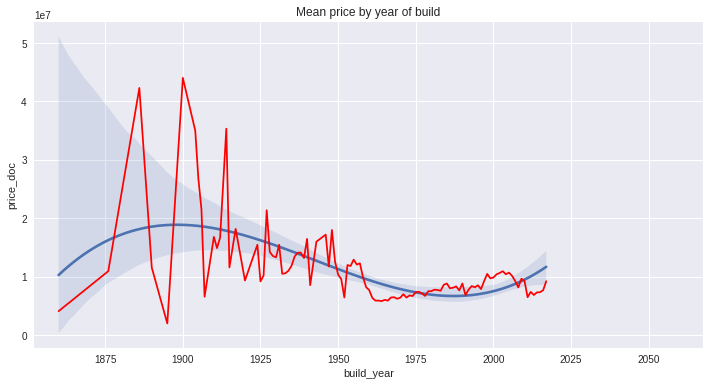

In [15]:
f, ax = plt.subplots(figsize=(12, 6))
by_price = by_df.groupby('build_year')[['build_year', 'price_doc']].mean()
sns.regplot(x="build_year", y="price_doc", data=by_price, scatter=False, order=3, truncate=True)
plt.plot(by_price['build_year'], by_price['price_doc'], color='r')
ax.set(title='Mean price by year of build')

## Timestamp

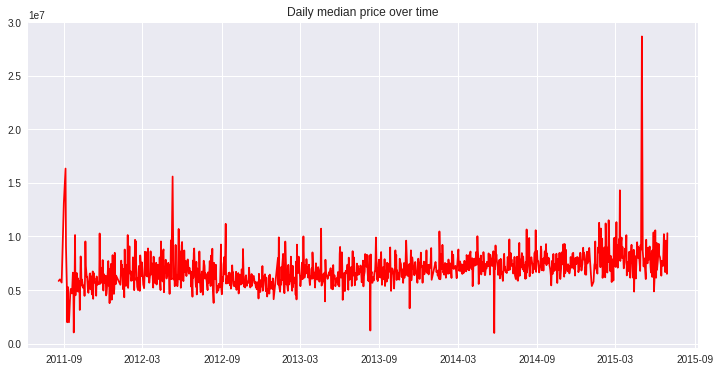

In [16]:
f, ax = plt.subplots(figsize=(12, 6))
ts_df = train_df.groupby('timestamp')[['price_doc']].mean()
#sns.regplot(x="timestamp", y="price_doc", data=ts_df, scatter=False, truncate=True)
plt.plot(ts_df.index, ts_df['price_doc'], color='r', )
ax.set(title='Daily median price over time')

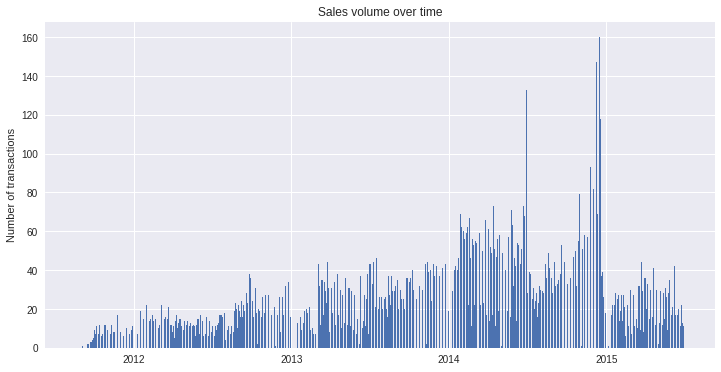

In [17]:
import datetime
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
yearsFmt = mdates.DateFormatter('%Y')
ts_vc = train_df['timestamp'].value_counts()
f, ax = plt.subplots(figsize=(12, 6))
plt.bar(left=ts_vc.index, height=ts_vc)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.set(title='Sales volume over time', ylabel='Number of transactions')

## Home State/Material

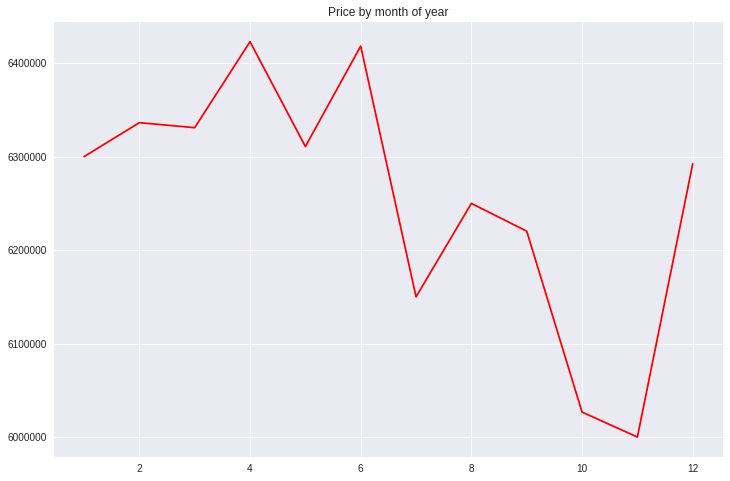

In [18]:
f, ax = plt.subplots(figsize=(12, 8))
ts_df = train_df.groupby(by=[train_df.timestamp.dt.month])[['price_doc']].median()
plt.plot(ts_df.index, ts_df, color='r')
ax.set(title='Price by month of year')

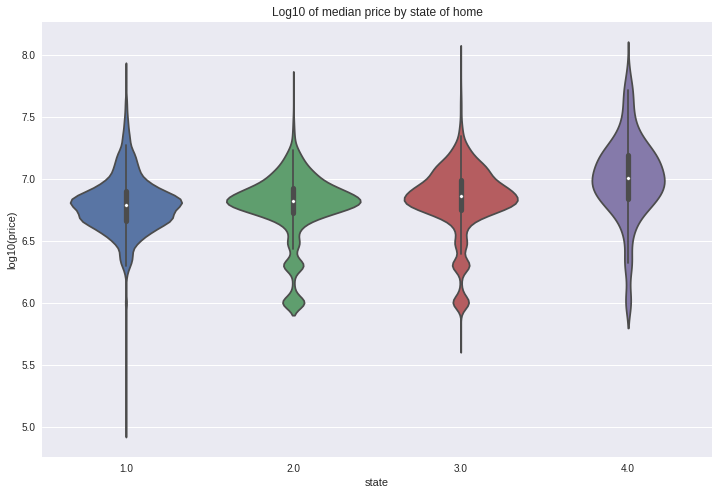

In [19]:
f, ax = plt.subplots(figsize=(12, 8))
ind = train_df[train_df['state'].isnull()].index
train_df['price_doc_log10'] = np.log10(train_df['price_doc'])
sns.violinplot(x="state", y="price_doc_log10", data=train_df.drop(ind), inner="box")
# sns.swarmplot(x="state", y="price_doc_log10", data=train_df.dropna(), color="w", alpha=.2);
ax.set(title='Log10 of median price by state of home', xlabel='state', ylabel='log10(price)')

In [20]:
train_df.drop(ind).groupby('state')['price_doc'].mean()

state
1.0     7315439
2.0     7060395
3.0     8078315
4.0    13345468
Name: price_doc, dtype: int64

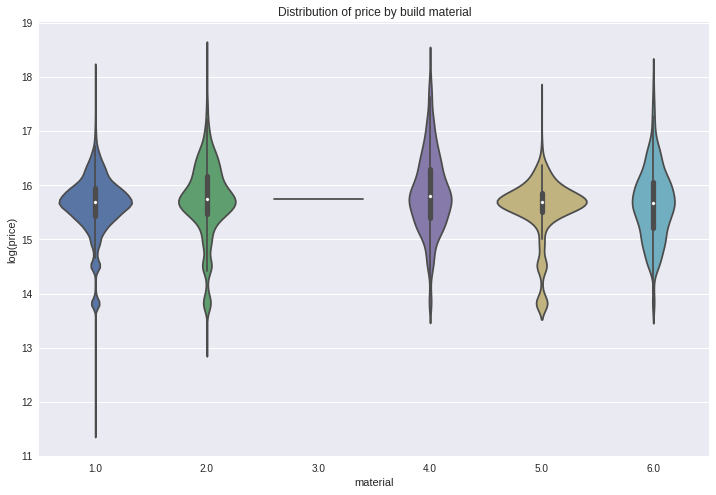

In [21]:
f, ax = plt.subplots(figsize=(12, 8))
ind = train_df[train_df['material'].isnull()].index
sns.violinplot(x="material", y="price_doc_log", data=train_df.drop(ind), inner="box")
# sns.swarmplot(x="state", y="price_doc_log10", data=train_df.dropna(), color="w", alpha=.2);
ax.set(title='Distribution of price by build material', xlabel='material', ylabel='log(price)')

In [22]:
train_df.drop(ind).groupby('material')['price_doc'].median()

material
1.0    6500000
2.0    6900000
3.0    6931143
4.0    7247869
5.0    6492000
6.0    6362318
Name: price_doc, dtype: int64

## Floor of Home

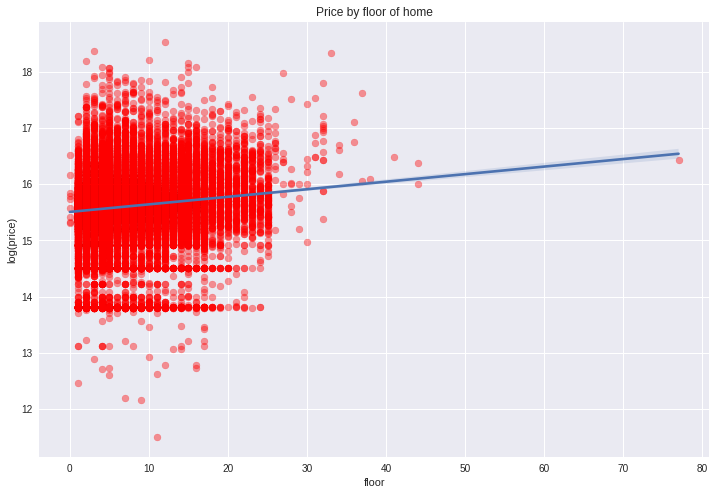

In [23]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x=train_df['floor'], y=train_df['price_doc_log'], c='r', alpha=0.4)
sns.regplot(x="floor", y="price_doc_log", data=train_df, scatter=False, truncate=True)
ax.set(title='Price by floor of home', xlabel='floor', ylabel='log(price)')

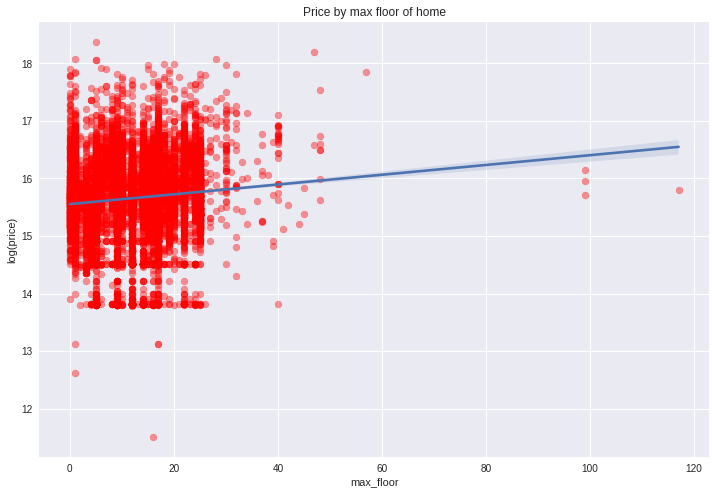

In [24]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x=train_df['max_floor'], y=train_df['price_doc_log'], c='r', alpha=0.4)
sns.regplot(x="max_floor", y="price_doc_log", data=train_df, scatter=False, truncate=True)
ax.set(title='Price by max floor of home', xlabel='max_floor', ylabel='log(price)')

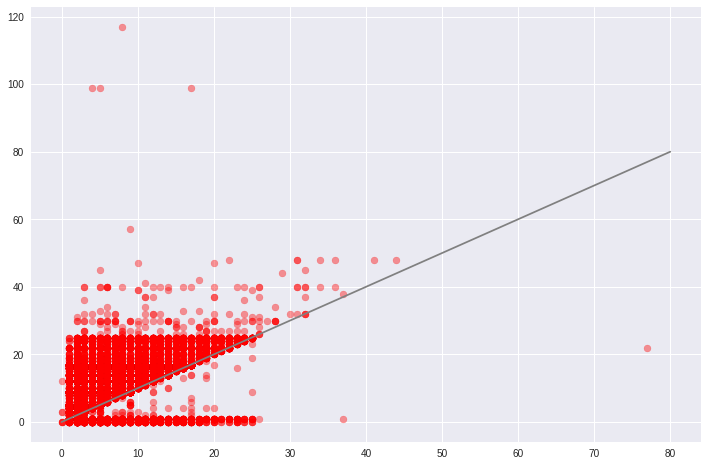

In [25]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x=train_df['floor'], y=train_df['max_floor'], c='r', alpha=0.4)
plt.plot([0, 80], [0, 80], color='.5')

In [26]:
train_df.loc[train_df['max_floor'] < train_df['floor'], ['id', 'floor','max_floor']].head(20)

,id,floor,max_floor
8216,8219,13.0,0.0
8268,8271,3.0,1.0
8499,8502,2.0,0.0
8531,8534,7.0,0.0
8912,8915,5.0,0.0
9161,9164,8.0,3.0
9257,9260,8.0,1.0
9309,9312,5.0,1.0
9388,9391,10.0,1.0
9412,9415,4.0,1.0


In [27]:
## Demographic Characteristics

In [28]:
demo_vars = ['area_m', 'raion_popul', 'full_all', 'male_f', 'female_f', 'young_all', 'young_female', 
             'work_all', 'work_male', 'work_female', 'price_doc']
corrmat = train_df[demo_vars].corr()

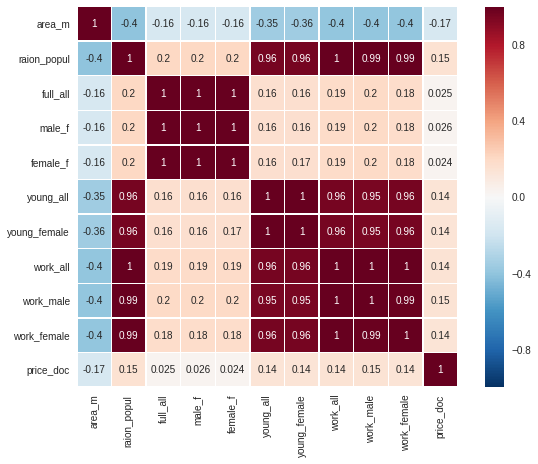

In [29]:
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

In [30]:
train_df['sub_area'].unique().shape[0]

146

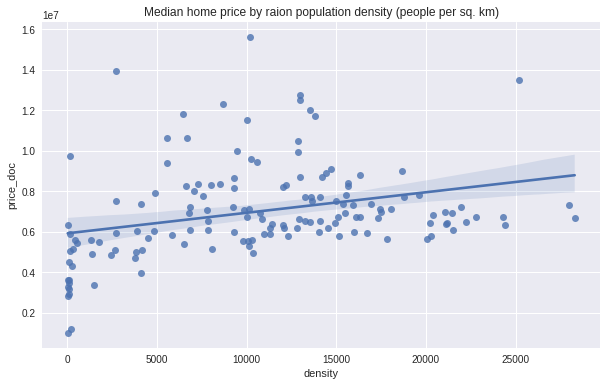

In [31]:
train_df['area_km'] = train_df['area_m'] / 1000000
train_df['density'] = train_df['raion_popul'] / train_df['area_km']
f, ax = plt.subplots(figsize=(10, 6))
sa_price = train_df.groupby('sub_area')[['density', 'price_doc']].median()
sns.regplot(x="density", y="price_doc", data=sa_price, scatter=True, truncate=True)
ax.set(title='Median home price by raion population density (people per sq. km)')

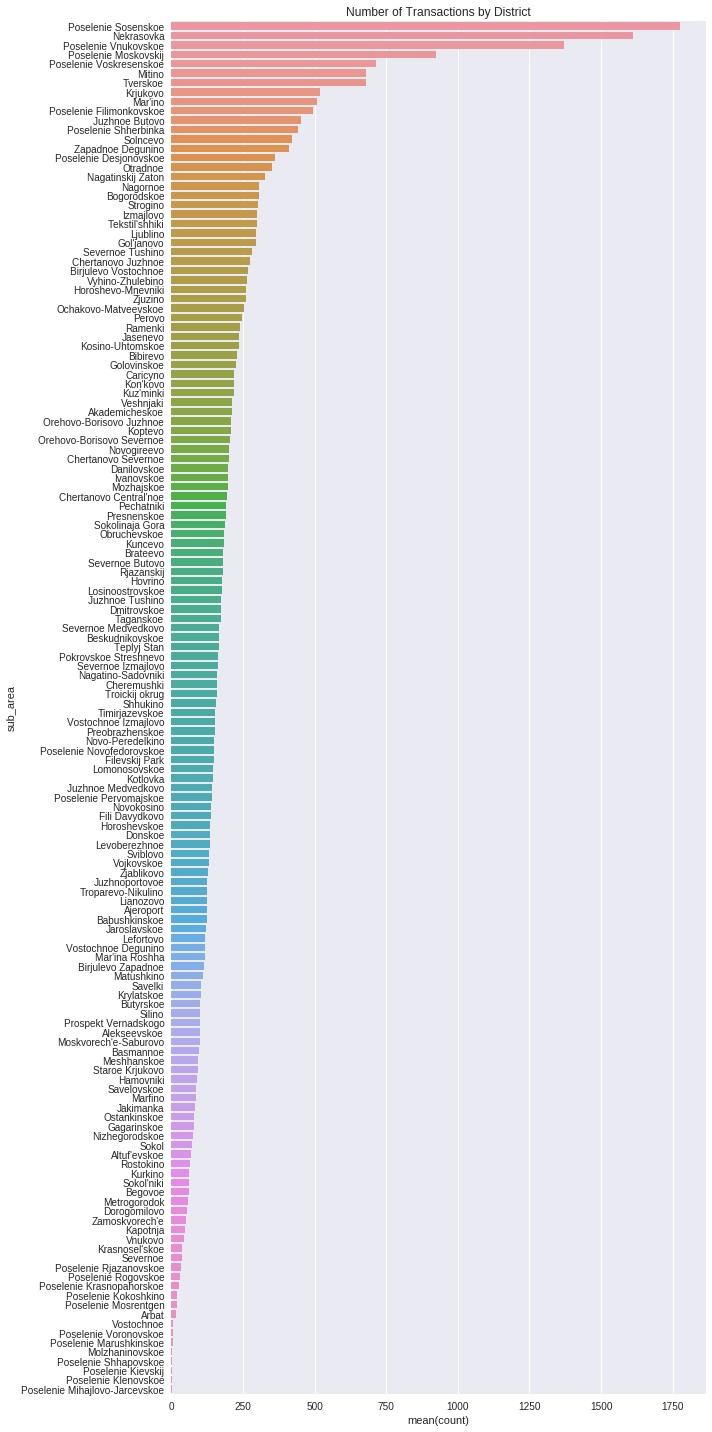

In [32]:
f, ax = plt.subplots(figsize=(10, 20))
sa_vc = train_df['sub_area'].value_counts()
sa_vc = pd.DataFrame({'sub_area':sa_vc.index, 'count': sa_vc.values})
ax = sns.barplot(x="count", y="sub_area", data=sa_vc, orient="h")
ax.set(title='Number of Transactions by District')
f.tight_layout()

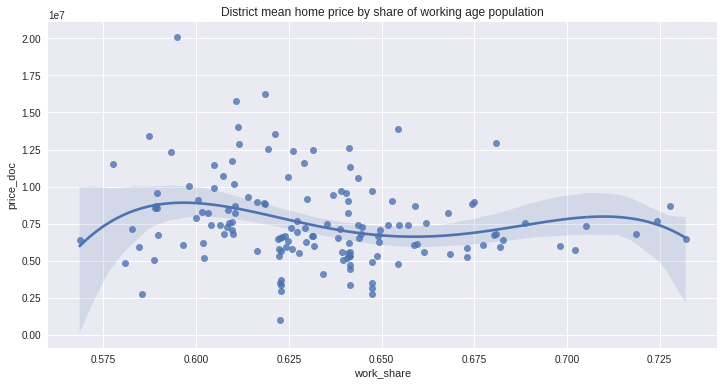

In [33]:
train_df['work_share'] = train_df['work_all'] / train_df['raion_popul']
f, ax = plt.subplots(figsize=(12, 6))
sa_price = train_df.groupby('sub_area')[['work_share', 'price_doc']].mean()
sns.regplot(x="work_share", y="price_doc", data=sa_price, scatter=True, order=4, truncate=True)
ax.set(title='District mean home price by share of working age population')

## School Characteristics

In [34]:
school_chars = ['children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 
                'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 
                'university_top_20_raion', 'additional_education_raion', 'additional_education_km', 'university_km', 'price_doc']
corrmat = train_df[school_chars].corr()

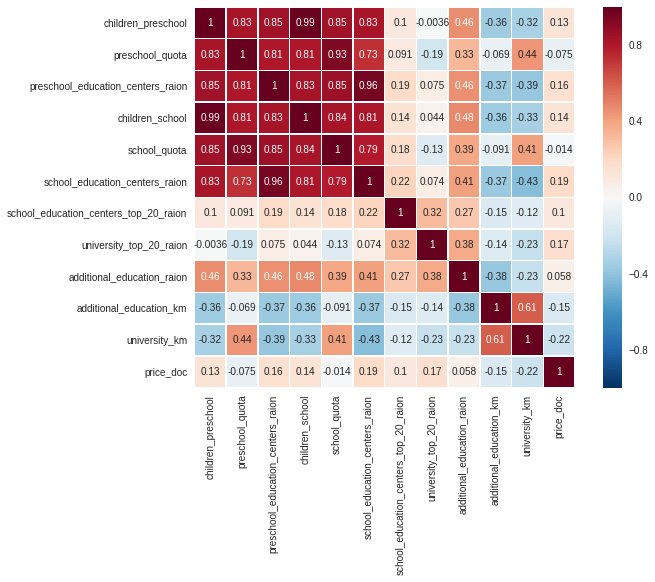

In [35]:
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

In [36]:
train_df['university_top_20_raion'].unique()

array([0, 2, 1, 3])

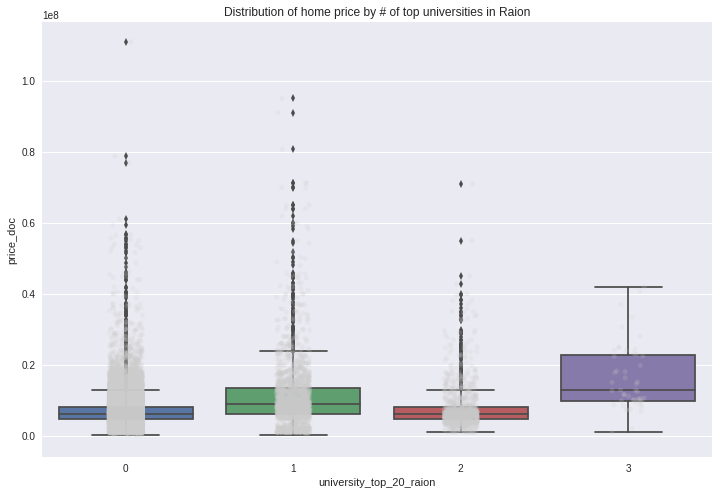

In [37]:
f, ax = plt.subplots(figsize=(12, 8))
sns.stripplot(x="university_top_20_raion", y="price_doc", data=train_df, jitter=True, alpha=.2, color=".8");
sns.boxplot(x="university_top_20_raion", y="price_doc", data=train_df)
ax.set(title='Distribution of home price by # of top universities in Raion', xlabel='university_top_20_raion', 
       ylabel='price_doc')

## Cultural/Recreational Characteristics

In [38]:
cult_chars = ['sport_objects_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'park_km', 'fitness_km', 
                'swim_pool_km', 'ice_rink_km','stadium_km', 'basketball_km', 'shopping_centers_km', 'big_church_km',
                'church_synagogue_km', 'mosque_km', 'theater_km', 'museum_km', 'exhibition_km', 'catering_km', 'price_doc']
corrmat = train_df[cult_chars].corr()

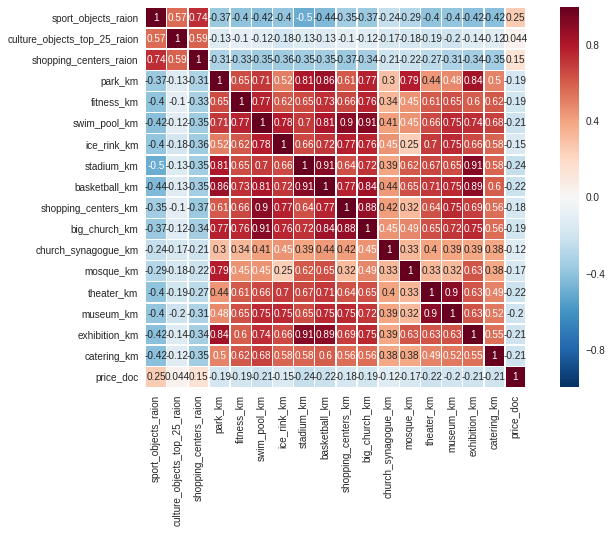

In [39]:
f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

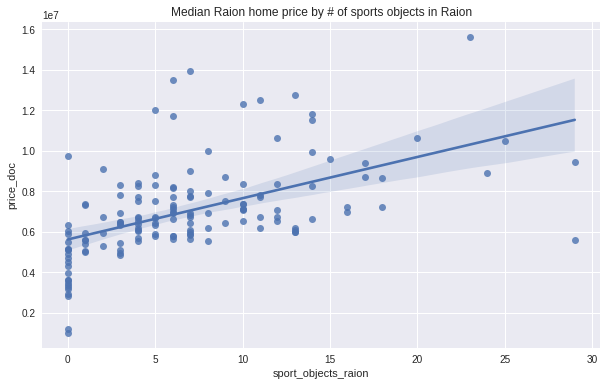

In [40]:
f, ax = plt.subplots(figsize=(10, 6))
so_price = train_df.groupby('sub_area')[['sport_objects_raion', 'price_doc']].median()
sns.regplot(x="sport_objects_raion", y="price_doc", data=so_price, scatter=True, truncate=True)
ax.set(title='Median Raion home price by # of sports objects in Raion')

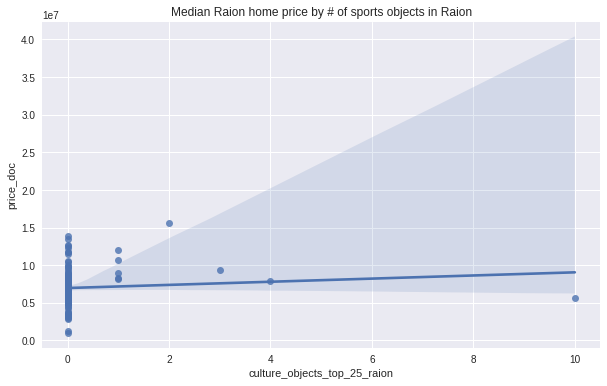

In [41]:
f, ax = plt.subplots(figsize=(10, 6))
co_price = train_df.groupby('sub_area')[['culture_objects_top_25_raion', 'price_doc']].median()
sns.regplot(x="culture_objects_top_25_raion", y="price_doc", data=co_price, scatter=True, truncate=True)
ax.set(title='Median Raion home price by # of sports objects in Raion')

In [42]:
train_df.groupby('culture_objects_top_25')['price_doc'].median()

culture_objects_top_25
no     6200000
yes    7400000
Name: price_doc, dtype: int64

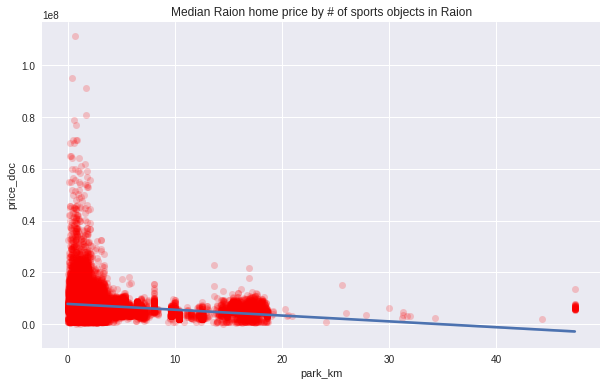

In [43]:
f, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x="park_km", y="price_doc", data=train_df, scatter=True, truncate=True, scatter_kws={'color': 'r', 'alpha': .2})
ax.set(title='Median Raion home price by # of sports objects in Raion')

## Infrastructure Features

In [44]:
inf_features = ['nuclear_reactor_km', 'thermal_power_plant_km', 'power_transmission_line_km', 'incineration_km',
                'water_treatment_km', 'incineration_km', 'railroad_station_walk_km', 'railroad_station_walk_min', 
                'railroad_station_avto_km', 'railroad_station_avto_min', 'public_transport_station_km', 
                'public_transport_station_min_walk', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km','bulvar_ring_km',
                'kremlin_km', 'price_doc']
corrmat = train_df[inf_features].corr()

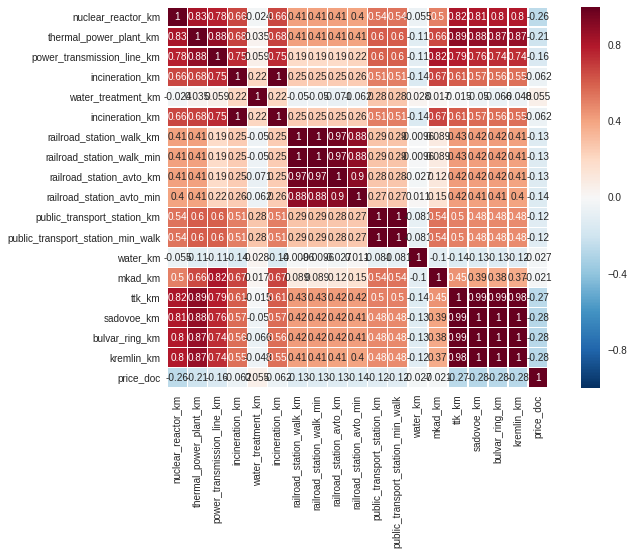

In [45]:
f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

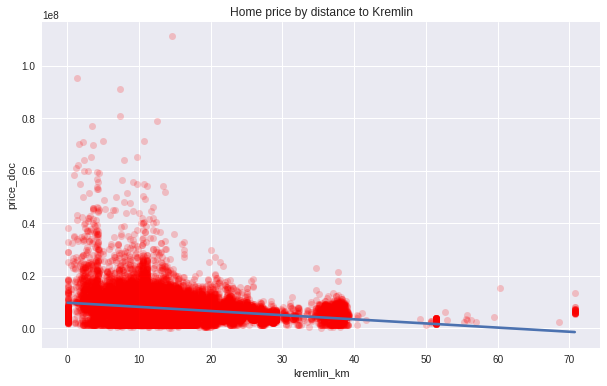

In [46]:
f, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x="kremlin_km", y="price_doc", data=train_df, scatter=True, truncate=True, scatter_kws={'color': 'r', 'alpha': .2})
ax.set(title='Home price by distance to Kremlin')

## Variable Importance

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
X_train = train_df.drop(labels=['timestamp', 'id', 'incineration_raion'], axis=1).dropna()
y_train = X_train['price_doc']
X_train.drop('price_doc', axis=1, inplace=True)
for f in X_train.columns:
    if X_train[f].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(X_train[f])
        X_train[f] = lbl.transform(X_train[f])
rf = RandomForestRegressor(random_state=0)
rf = rf.fit(X_train, y_train)

In [48]:
fi = list(zip(X_train.columns, rf.feature_importances_))
print('## rf variable importance')
d = [print('## %-40s%s' % (i)) for i in fi[:20]]

## rf variable importance
## full_sq                                 5.87095874356e-07
## life_sq                                 9.04347628546e-08
## floor                                   1.20590421994e-08
## max_floor                               1.20794309636e-07
## material                                7.64088471083e-08
## build_year                              5.56703735125e-05
## num_room                                1.18520322785e-06
## kitch_sq                                5.87408823402e-08
## state                                   1.4491456575e-07
## product_type                            2.21240486991e-08
## sub_area                                5.77751434752e-09
## area_m                                  6.22619361625e-07
## raion_popul                             2.39214582143e-08
## green_zone_part                         2.57185801048e-07
## indust_part                             5.86329500469e-08
## children_preschool                      4.39636702546e-08

## Train vs Test Data

In [49]:
test_df = pd.read_csv("../input/test.csv", parse_dates=['timestamp'])
test_na = (test_df.isnull().sum() / len(test_df)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)

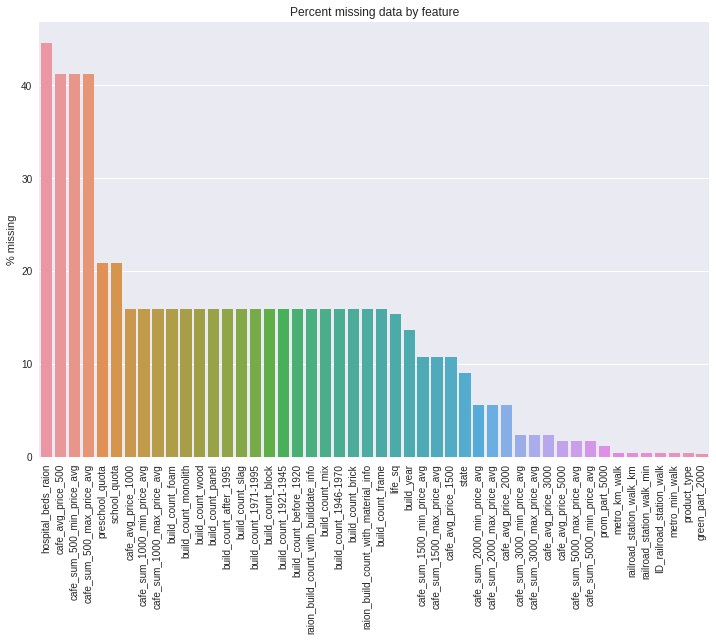

In [50]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90')
sns.barplot(x=test_na.index, y=test_na)
ax.set(title='Percent missing data by feature', ylabel='% missing')

In [51]:
all_data = pd.concat([train_df.drop('price_doc', axis=1), test_df])
all_data['dataset'] = ''
l = len(train_df)
all_data.iloc[:l]['dataset'] = 'train'
all_data.iloc[l:]['dataset'] = 'test'
train_dataset = all_data['dataset'] == 'train'

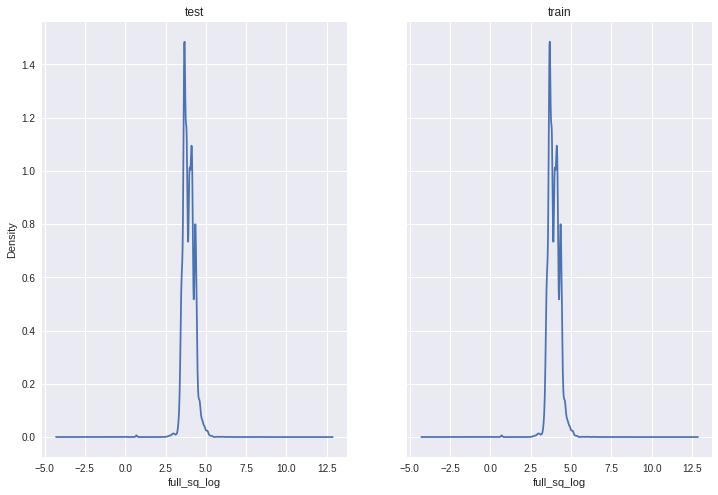

In [52]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
all_data['full_sq_log'] = np.log1p(all_data['full_sq'])
all_data.drop(train_dataset)["full_sq_log"].plot.kde(ax=ax[0])
all_data.drop(~train_dataset)["full_sq_log"].plot.kde(ax=ax[1])
ax[0].set(title='test', xlabel='full_sq_log')
ax[1].set(title='train', xlabel='full_sq_log')

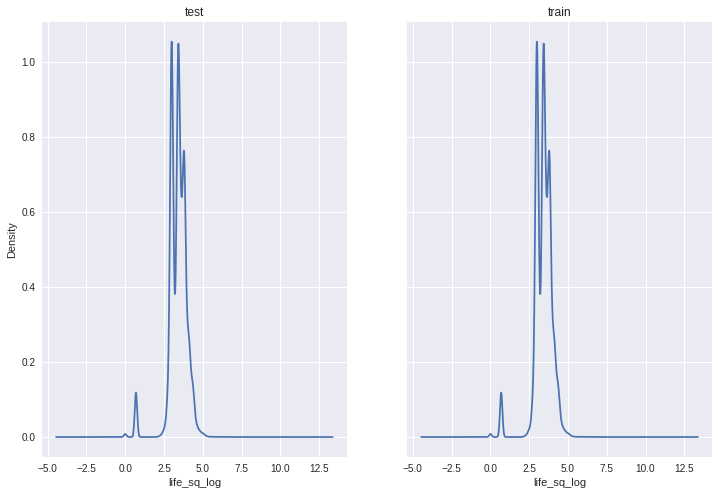

In [53]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
all_data['life_sq_log'] = np.log1p(all_data['life_sq'])
all_data.drop(train_dataset)["life_sq_log"].plot.kde(ax=ax[0])
all_data.drop(~train_dataset)["life_sq_log"].plot.kde(ax=ax[1])
ax[0].set(title='test', xlabel='life_sq_log')
ax[1].set(title='train', xlabel='life_sq_log')

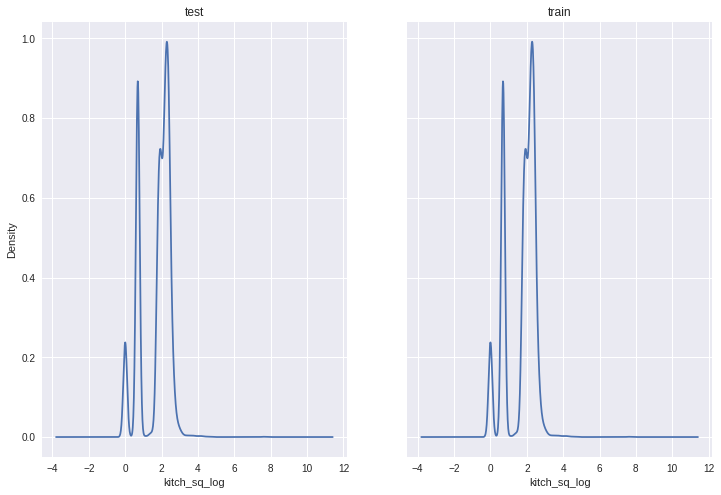

In [54]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
all_data['kitch_sq_log'] = np.log1p(all_data['kitch_sq'])
all_data.drop(train_dataset)["kitch_sq_log"].plot.kde(ax=ax[0])
all_data.drop(~train_dataset)["kitch_sq_log"].plot.kde(ax=ax[1])
ax[0].set(title='test', xlabel='kitch_sq_log')
ax[1].set(title='train', xlabel='kitch_sq_log')

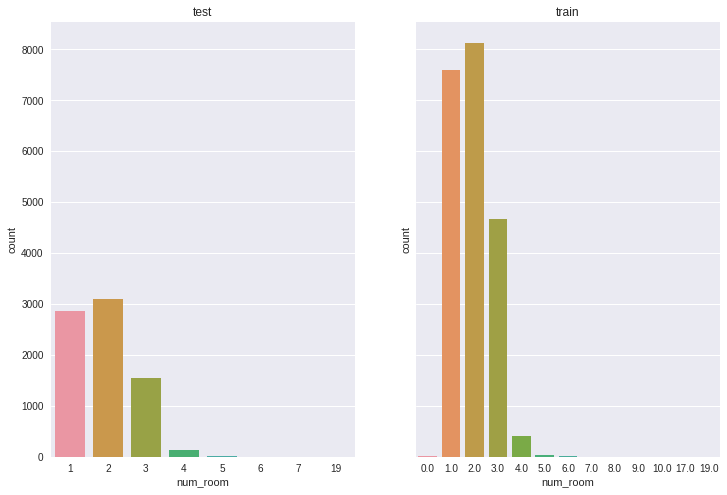

In [55]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
sns.countplot(x=test_df['num_room'], ax=ax[0])
sns.countplot(x=train_df['num_room'], ax=ax[1])
ax[0].set(title='test', xlabel='num_room')
ax[1].set(title='train', xlabel='num_room')

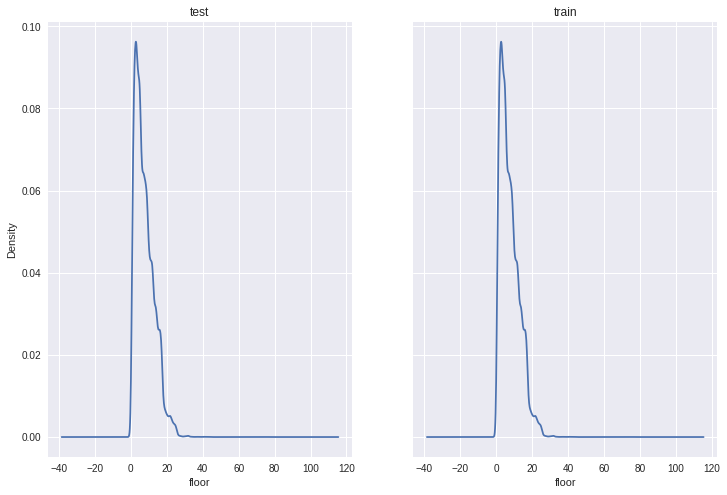

In [56]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
all_data.drop(train_dataset)["floor"].plot.kde(ax=ax[0])
all_data.drop(~train_dataset)["floor"].plot.kde(ax=ax[1])
ax[0].set(title='test', xlabel='floor')
ax[1].set(title='train', xlabel='floor')

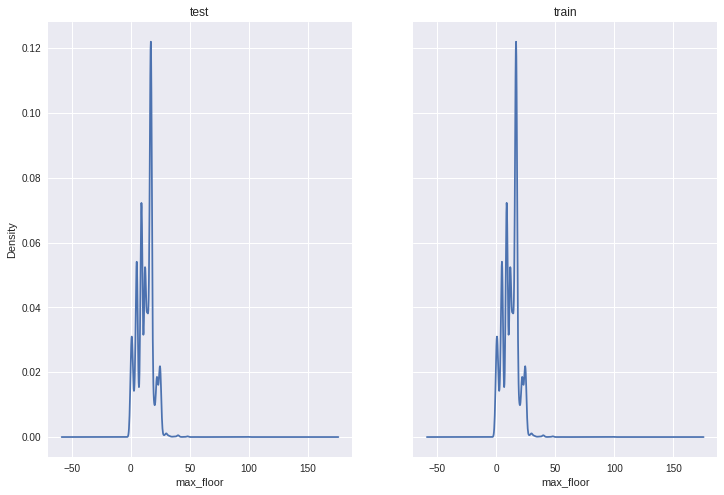

In [57]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
all_data.drop(train_dataset)["max_floor"].plot.kde(ax=ax[0])
all_data.drop(~train_dataset)["max_floor"].plot.kde(ax=ax[1])
ax[0].set(title='test', xlabel='max_floor')
ax[1].set(title='train', xlabel='max_floor')

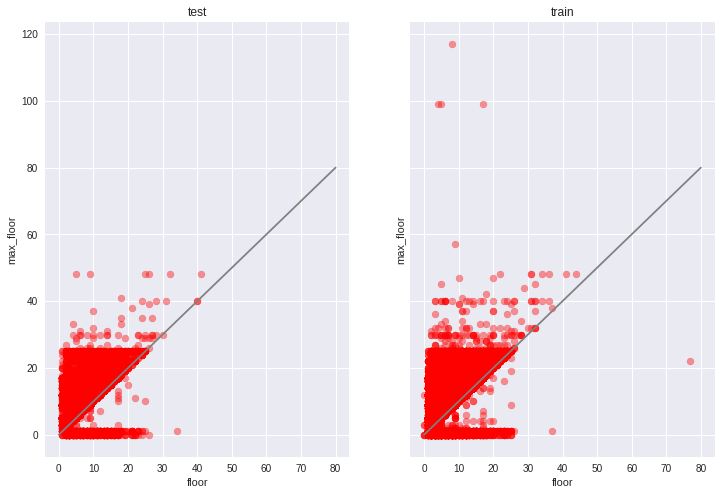

In [58]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
ax[0].scatter(x=test_df['floor'], y=test_df['max_floor'], c='r', alpha=0.4)
ax[0].plot([0, 80], [0, 80], color='.5')
ax[1].scatter(x=train_df['floor'], y=train_df['max_floor'], c='r', alpha=0.4)
ax[1].plot([0, 80], [0, 80], color='.5')
ax[0].set(title='test', xlabel='floor', ylabel='max_floor')
ax[1].set(title='train', xlabel='floor', ylabel='max_floor')

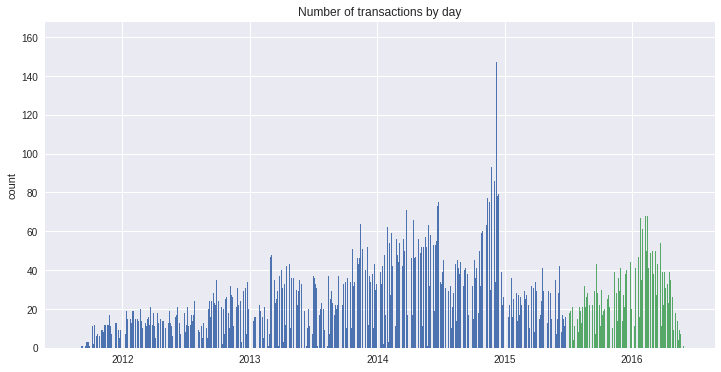

In [59]:
years = mdates.YearLocator()   # every year
yearsFmt = mdates.DateFormatter('%Y')
ts_vc_train = train_df['timestamp'].value_counts()
ts_vc_test = test_df['timestamp'].value_counts()
f, ax = plt.subplots(figsize=(12, 6))
plt.bar(left=ts_vc_train.index, height=ts_vc_train)
plt.bar(left=ts_vc_test.index, height=ts_vc_test)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.set(title='Number of transactions by day', ylabel='count')

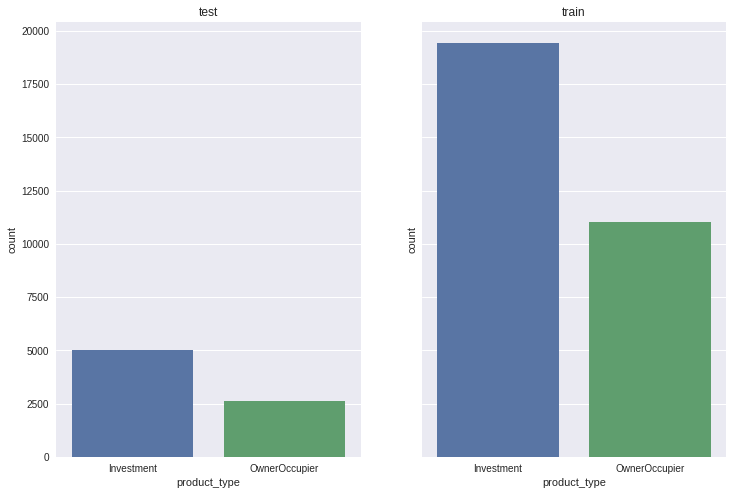

In [60]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
sns.countplot(x=test_df['product_type'], ax=ax[0])
sns.countplot(x=train_df['product_type'], ax=ax[1])
ax[0].set(title='test', xlabel='product_type')
ax[1].set(title='train', xlabel='product_type')

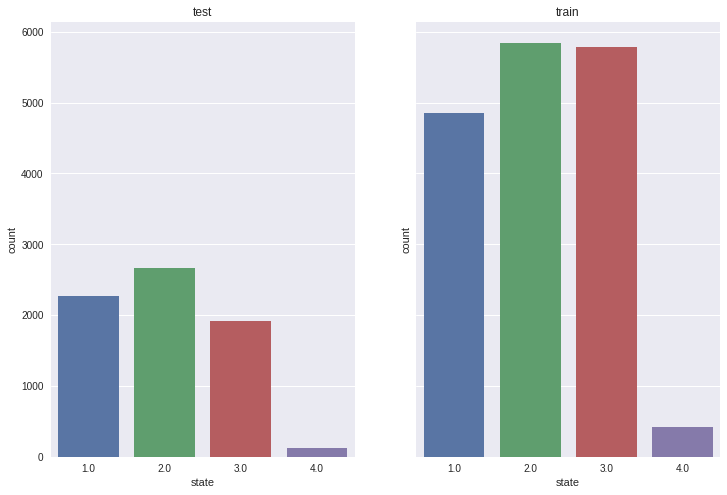

In [61]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
sns.countplot(x=test_df['state'], ax=ax[0])
sns.countplot(x=train_df['state'], ax=ax[1])
ax[0].set(title='test', xlabel='state')
ax[1].set(title='train', xlabel='state')

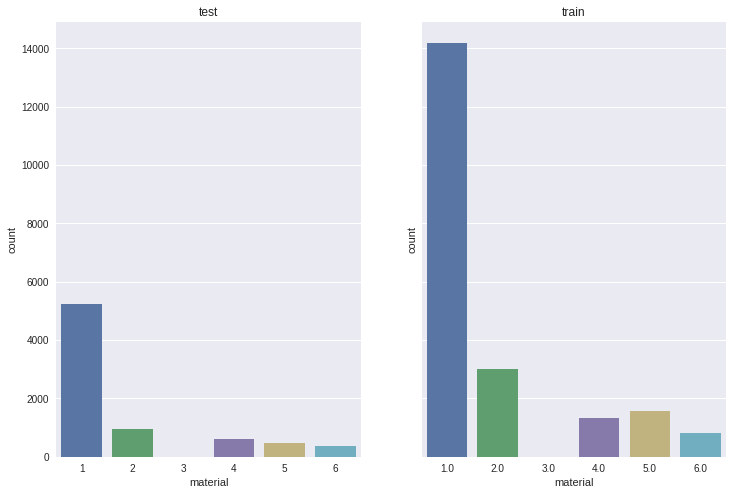

In [62]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
sns.countplot(x=test_df['material'], ax=ax[0])
sns.countplot(x=train_df['material'], ax=ax[1])
ax[0].set(title='test', xlabel='material')
ax[1].set(title='train', xlabel='material')